In [163]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
pd.set_option("display.max_columns",80)

In [164]:
dataset = r"E:\StudyLAB\thesis_final\data_novisi.csv"
df = pd.read_csv(dataset)
df = df.dropna(how='any',axis=0)
df.shape
print(df)

       hour  rain  temp  pressure  humidity  wind_spd  NUMACC  distance  \
0        17   0.0    26    968.13        52        15       1    148.92   
1        17   0.0    32    968.13        52        15       1   2590.93   
2        21   0.0    29    971.02        62        13       1    206.07   
3         1   0.0    26    969.09        69         7       1    121.65   
4        10   0.0    30    971.98        58         9       1     95.58   
...     ...   ...   ...       ...       ...       ...     ...       ...   
10926    17   0.0    33    965.24        89         6       0    120.91   
10927     2   0.0    26    969.09        79         4       0    456.88   
10928    12   0.7    31    971.02        89         4       0    310.94   
10929     3   0.0    25    971.02        62         2       0    166.58   
10930    19   0.5    29    969.09        89         7       0     31.33   

       ROAD_TYPE  SURFACE  WIDTH  LANE  ONEWAY  Speed  
0              6        2      5     2     

In [165]:
cm_field = ['ROAD_TYPE','SURFACE','ONEWAY','LANE','hour']
df_cm = pd.get_dummies(df,columns=cm_field)
cm_feature_names = pd.get_dummies(df[cm_field],columns=cm_field).columns.tolist()
df_cm.head(5)
# print(cm_feature_names)

,rain,temp,pressure,humidity,wind_spd,NUMACC,distance,WIDTH,Speed,ROAD_TYPE_1,ROAD_TYPE_2,ROAD_TYPE_3,ROAD_TYPE_5,ROAD_TYPE_6,ROAD_TYPE_7,ROAD_TYPE_9,SURFACE_1,SURFACE_2,SURFACE_3,SURFACE_9,ONEWAY_0,ONEWAY_1,LANE_1,LANE_2,LANE_3,LANE_4,LANE_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.0,26,968.13,52,15,1,148.92,5,45,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.0,32,968.13,52,15,1,2590.93,10,55,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.0,29,971.02,62,13,1,206.07,12,45,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.0,26,969.09,69,7,1,121.65,12,45,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,30,971.98,58,9,1,95.58,10,45,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
df['Speed'].astype('float')

0        45.0
1        55.0
2        45.0
3        45.0
4        45.0
         ... 
10926    45.0
10927    55.0
10928    55.0
10929    70.0
10930    45.0
Name: Speed, Length: 10931, dtype: float64

In [167]:
df
float_feature_names =['distance','rain','temp','wind_spd','Speed','WIDTH','humidity','pressure']

float_features = df_cm.xs(float_feature_names,axis=1).values
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
print (float_features.mean(axis=0))
# df_cm[float_feature_names] = float_scaled
with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

[560.18555027   2.71203001  26.89150124   6.39447443  51.49162931
   7.44414967  67.81465557 974.73269051]


In [168]:
y = df['NUMACC'].values
df_cm = df_cm.xs(float_feature_names+cm_feature_names,axis=1)
df_cm.head()

,distance,rain,temp,wind_spd,Speed,WIDTH,humidity,pressure,ROAD_TYPE_1,ROAD_TYPE_2,ROAD_TYPE_3,ROAD_TYPE_5,ROAD_TYPE_6,ROAD_TYPE_7,ROAD_TYPE_9,SURFACE_1,SURFACE_2,SURFACE_3,SURFACE_9,ONEWAY_0,ONEWAY_1,LANE_1,LANE_2,LANE_3,LANE_4,LANE_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,148.92,0.0,26,15,45,5,52,968.13,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2590.93,0.0,32,15,55,10,52,968.13,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,206.07,0.0,29,13,45,12,62,971.02,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,121.65,0.0,26,7,45,12,69,969.09,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,95.58,0.0,30,9,45,10,58,971.98,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [169]:
X= df_cm.values
y = df['NUMACC'].values
feature_names = df_cm.columns.tolist()
print(X)


[[1.48920e+02 0.00000e+00 2.60000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.59093e+03 0.00000e+00 3.20000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.06070e+02 0.00000e+00 2.90000e+01 ... 1.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [3.10940e+02 7.00000e-01 3.10000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.66580e+02 0.00000e+00 2.50000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.13300e+01 5.00000e-01 2.90000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


In [170]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'cm_fields': cm_field,
    'feature_names': feature_names,
   
}
with open('wrangler_new.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [171]:
feature_sel = range(len(feature_names))

#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
print(Xs)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]
print(X_train)

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'max_depth':9,
    'min_child_weight': 4.0,
    'reg_lambda': 0.8,
    'reg_alpha':0.0,
    'scale_pos_weight':1.2,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.4
}

[[1.48920e+02 0.00000e+00 2.60000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.59093e+03 0.00000e+00 3.20000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.06070e+02 0.00000e+00 2.90000e+01 ... 1.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [3.10940e+02 7.00000e-01 3.10000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.66580e+02 0.00000e+00 2.50000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.13300e+01 5.00000e-01 2.90000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[[1.4292e+02 4.0000e-01 2.5000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.2987e+02 0.0000e+00 2.9000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [9.2460e+01 0.0000e+00 3.0000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.5080e+02 0.0000e+00 2.4000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.9905e+02 0.0000e+00 3.5000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.5190e+02 0.0000e+00 2.6000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [172]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[0]	eval-auc:0.68756
[1]	eval-auc:0.68456
[2]	eval-auc:0.72767
[3]	eval-auc:0.72800
[4]	eval-auc:0.73218
[5]	eval-auc:0.73742
[6]	eval-auc:0.73399
[7]	eval-auc:0.74768
[8]	eval-auc:0.75496
[9]	eval-auc:0.75228
[10]	eval-auc:0.76288
[11]	eval-auc:0.76492
[12]	eval-auc:0.76841
[13]	eval-auc:0.76808
[14]	eval-auc:0.76865
[15]	eval-auc:0.76765
[16]	eval-auc:0.76661
[17]	eval-auc:0.76950
[18]	eval-auc:0.77172
[19]	eval-auc:0.77121
[20]	eval-auc:0.77143
[21]	eval-auc:0.77333
[22]	eval-auc:0.77180
[23]	eval-auc:0.76983
[24]	eval-auc:0.76945
[25]	eval-auc:0.76965
[26]	eval-auc:0.77077
[27]	eval-auc:0.76976
[28]	eval-auc:0.76942
[29]	eval-auc:0.77015
[30]	eval-auc:0.76742
[31]	eval-auc:0.76551
[32]	eval-auc:0.76544
[33]	eval-auc:0.77090
[34]	eval-auc:0.76921
[35]	eval-auc:0.77011
[36]	eval-auc:0.77286
[37]	eval-auc:0.77438
[38]	eval-auc:0.77536
[39]	eval-auc:0.77482
[40]	eval-auc:0.77291
[41]	eval-auc:0.77277
[42]	eval-auc:0.77269
[43]	eval-auc:0.77105
[44]	eval-auc:0.77137
[45]	eval-auc:0.7730

In [61]:
import joblib
joblib.dump(booster,'accmodel2.joblib')

['accmodel2.joblib']

In [173]:
pred=booster.predict(dtest)
# Rs = r2_score(y_test, pred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
# print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))


The root mean squared is 0.4381


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

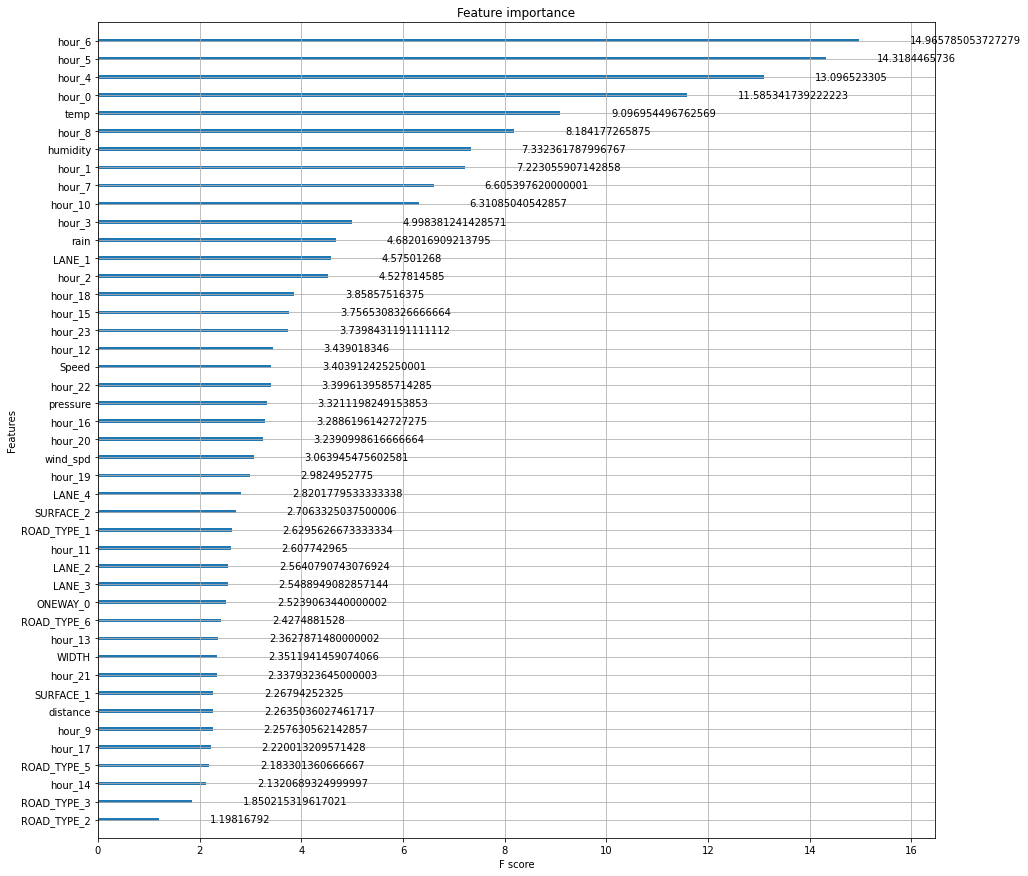

In [84]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='gain')

In [174]:
booster.predict(dtest)

array([0.6193631 , 0.7511913 , 0.7825299 , ..., 0.90173656, 0.6294953 ,
       0.7239876 ], dtype=float32)

In [175]:
y_pred_test = booster.predict(dtest) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.70018281535649
Test F1: 0.7660485021398002
Test Precision: 0.6340023612750886
Test Recall: 0.9675675675675676
Test AUC: 0.772451486737201
Test AP: 0.7017449035310009
Train Accuracy: 0.7653756226491817
Train F1: 0.8101349128002632
Train Precision: 0.6809569907343382
Train Recall: 0.9997969543147208
Train AUC: 0.9863372616941416
Test AP: 0.9856761580558103


In [82]:

def plot_split_histogram(feature_name):
    hist = booster.get_split_value_histogram(feature_name)
    try:
        i = float_feature_names.index(feature_name)
        fake_data = np.zeros((hist.Count.size,len(float_feature_names)))
        fake_data[:,i] = hist.SplitValue
        hist.loc[:,'SplitValue'] = scaler.inverse_transform(fake_data)[:,i]
    except: pass
    hist.plot(kind='area',x='SplitValue',y='Count')

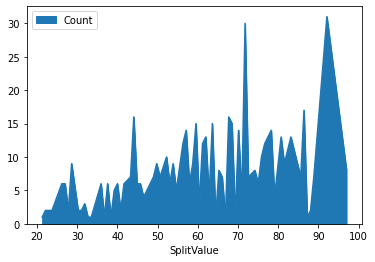

In [86]:

plot_split_histogram('humidity')

C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/661701610.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/661701610.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:" (-> color='r'). The keyword argument will take precedence.
  plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)


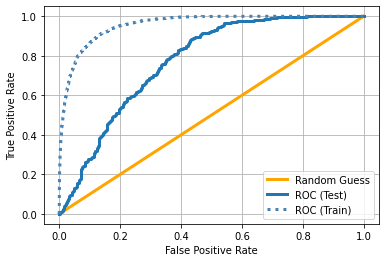

In [129]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/542219630.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/542219630.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r:" (-> color='r'). The keyword argument will take precedence.
  plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/542219630.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
C:\Users\Baannana\AppData\Local\Temp/ipykernel_12644/542219630.py:4: UserWarning: color is red

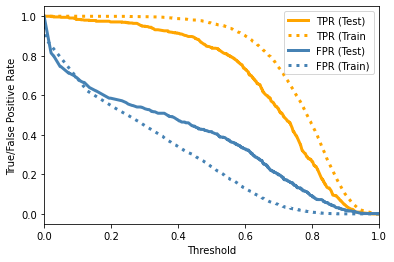

In [130]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'3.4.0'

<Figure size 1080x1080 with 0 Axes>

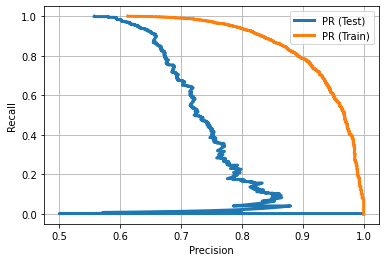

In [103]:

plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest)
y_pred_train = booster.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

In [151]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
mean_absolute_error(y_test, y_pred_test)

print ('TEST AUC:',metrics.auc(fpr, tpr))
print ('TEST MAE:',mean_absolute_error(y_test, y_pred_test))
print ('TEST ME:',max_error(y_test, y_pred_test))





TEST AUC: 0.7743975823059025
TEST MAE: 0.35004691402863547
TEST ME: 0.9821431040763855


In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_test, y_test)>1)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

ValueError: plot_confusion_matrix only supports classifiers